In [1]:
import numpy as np
from scipy import signal
from scipy.signal import hilbert, welch, butter, freqz, lfilter, correlate, correlation_lags, find_peaks
from scipy.fft import fft, fftfreq, irfft, dct, idct
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sig_analize as sigan

In [4]:
image_path = "./drop-250925-4/170.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

h, w = img.shape
y_centr = h//2

In [5]:
## Import of a ignal from json file 

import json

path = "./averaged_imgs.txt"
with open(path, 'r') as f:
    img_data = json.load(f)

sig = np.array(img_data[4][4])
sig_len = len(sig)
print(sig_len)
sig_x = list(range(sig_len))

19


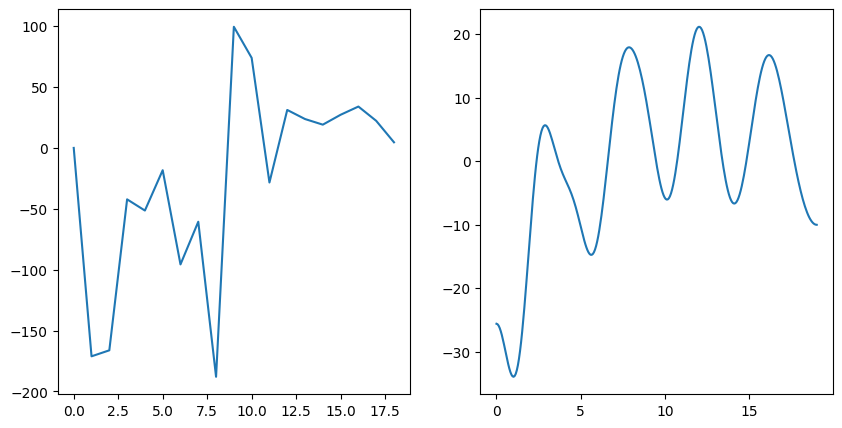

In [6]:
dct_coeff = dct(sig)

N = 300
x = np.linspace(0,sig_len, N)
k = np.arange(sig_len)

y_map = map(lambda a: 1/sig_len*np.sum(dct_coeff*np.cos(np.pi/sig_len*k*a)),x) 
y = np.array(list(y_map))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(dct_coeff)
ax2.plot(x, y)

In [35]:
## Fourie Spectr of initial signal

f = fftfreq(sig_len,1) # get frequences from fft
fft_coef = fft(sig)

In [8]:
## From Fourie coefficients we will restore the function
## with better resolution without constant component

N = 300
sig_sm_x, sig_sm = sigan.fourie_restore(dct_coeff, sig_len, fs=1, N=N, mode='cos')

In [33]:
### Fourie Spectr of the smoother initial signal, restored from "fft_coef"

f_new = fftfreq(N, sig_len/N)
fft_coef_new = fft(sig_sm)

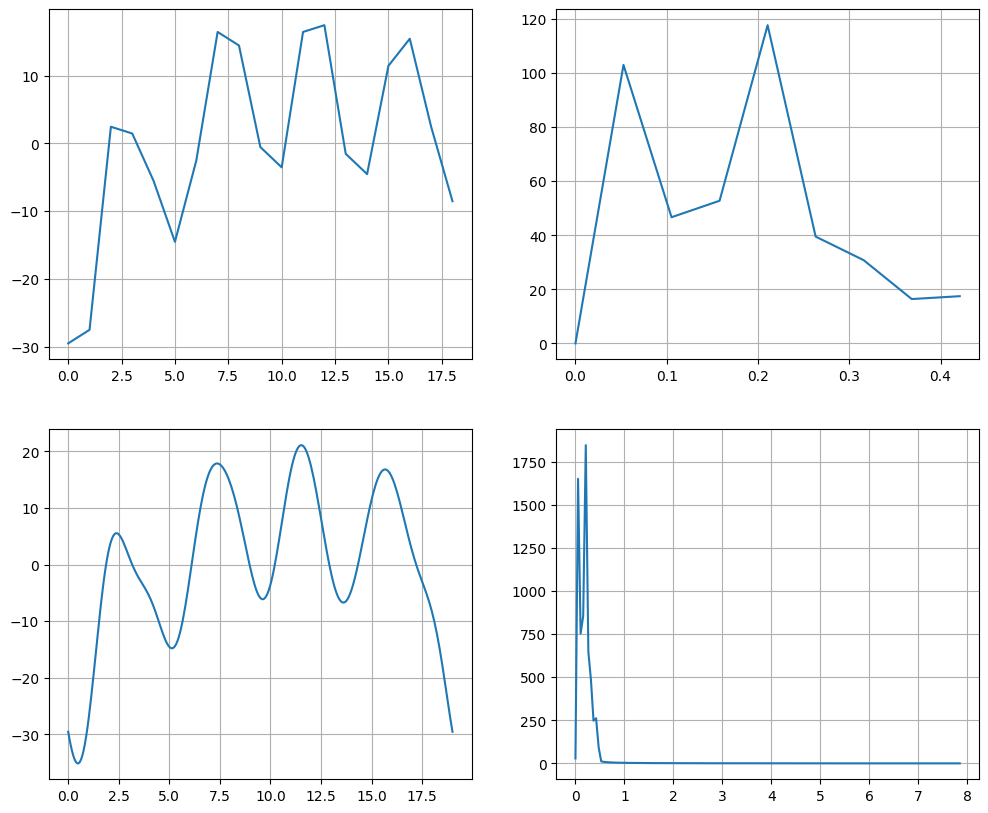

In [36]:
## Plot the initial_signal, recovered signal and their specrtra

plt.rcParams['axes.grid'] = True

fig, ax = plt.subplots(2,2, figsize=(12, 10)) 

ax[0][0].plot(sig_x, sig) # original signal
#ax[0].set_xticks(np.arange(0, 175, 5))

ax[1][0].plot(sig_sm_x, np.real(sig_sm))       # retrieved from furie coeffitients

ax[0][1].plot(f[0:sig_len//2], np.abs(fft_coef[0:sig_len//2])) # original spectr
ax[1][1].plot(f_new[0:N//2], np.abs(fft_coef_new[0:N//2]))     # improved spectr



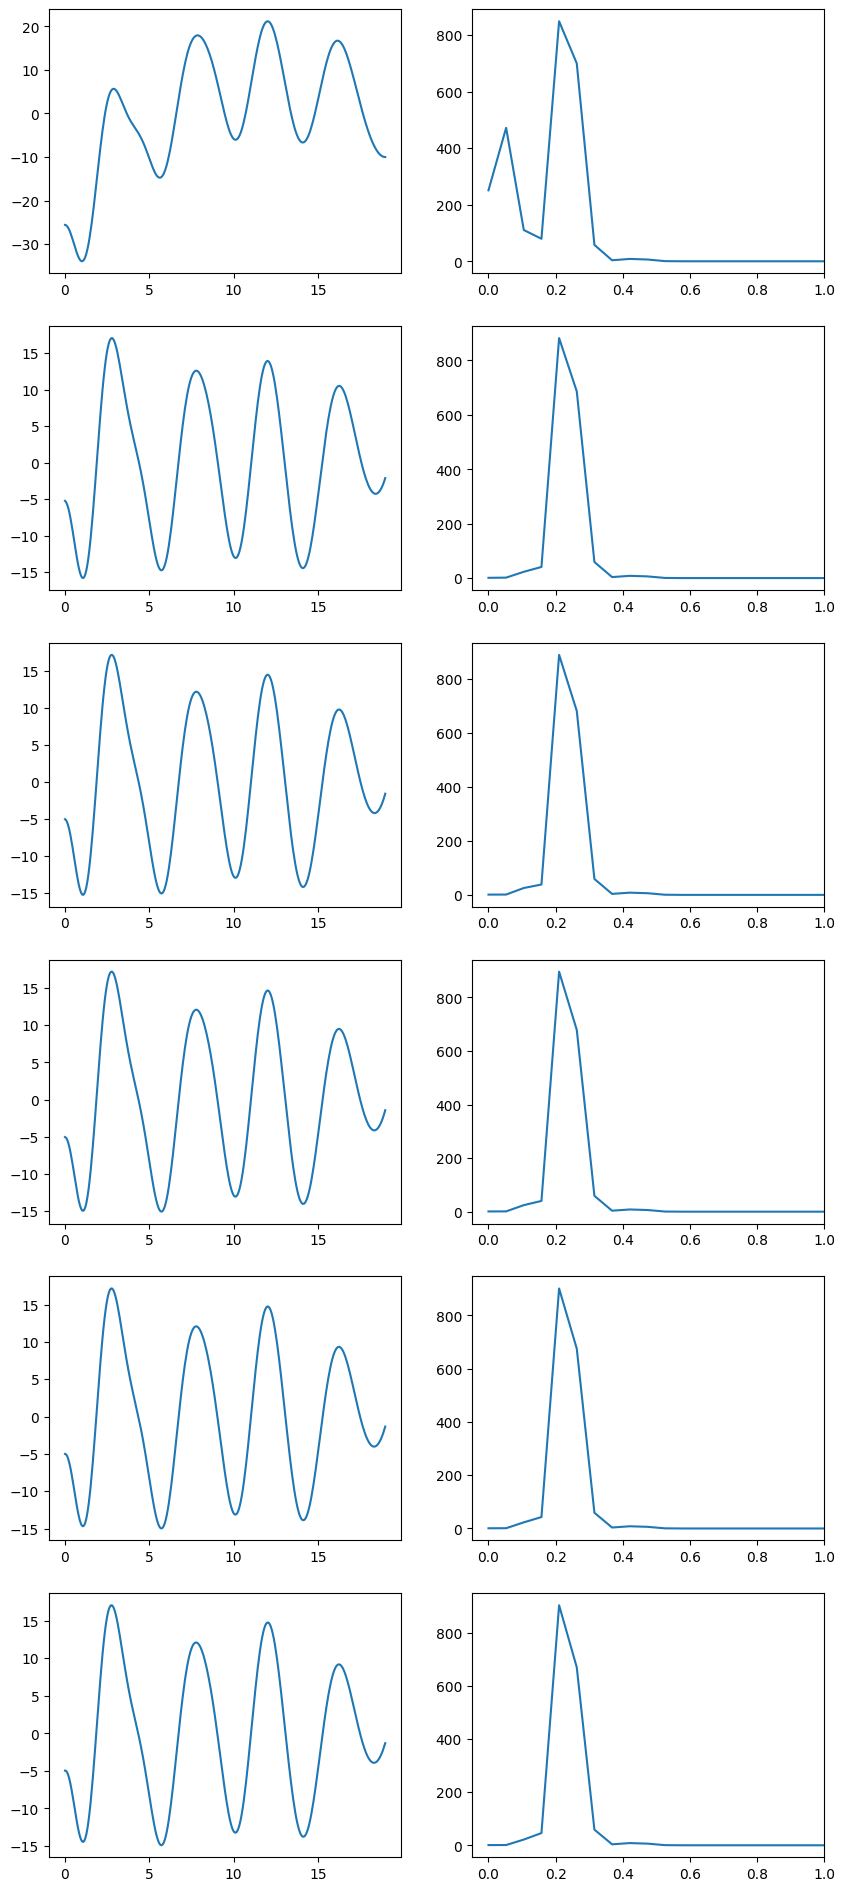

In [9]:
# my_butter_high in a loop with nl=0.5

sig_loop = sig_sm
sig_loop_x = sig_sm_x

sig_ll = len(sig_loop)
fsl = 0.5*sig_ll/sig_len
dtl = sig_ll/sig_len

b, a = sigan.my_butter_high(fq0 = 1/sig_len,fs=fsl, nl = 1)
w, h = freqz(b, a, fs = 2*np.pi*N/sig_len)
fxx, Pxx_den = welch(np.real(sig_loop), fs = dtl, nperseg=sig_ll)

n = 5
fig, ax = plt.subplots(n+1,2,figsize=(10,4*(n+1)))


ax[0,0].plot(sig_loop_x, sig_loop)
ax[0,1].plot(fxx, Pxx_den)#/np.max(Pxx_den), w/2/np.pi, np.abs(h))

for i in range(n+1):
    ax[i,1].set_xlim(-0.05,1)

for i in range(n):
    sig_loop = signal.filtfilt(b, a, sig_loop)
    fxx, Pxx_den = welch(np.real(sig_loop), fs = dtl, nperseg=sig_ll)
    
    ax[i+1,0].plot(sig_loop_x, sig_loop)
    ax[i+1,1].plot(fxx, Pxx_den)#, w/2/np.pi, np.abs(h))

(array([312.50025071, 139.76774545,   5.29237196]), array([0.1, 3.1, 7.1]), array([1.38653701, 5.88054989, 8.34226579]))


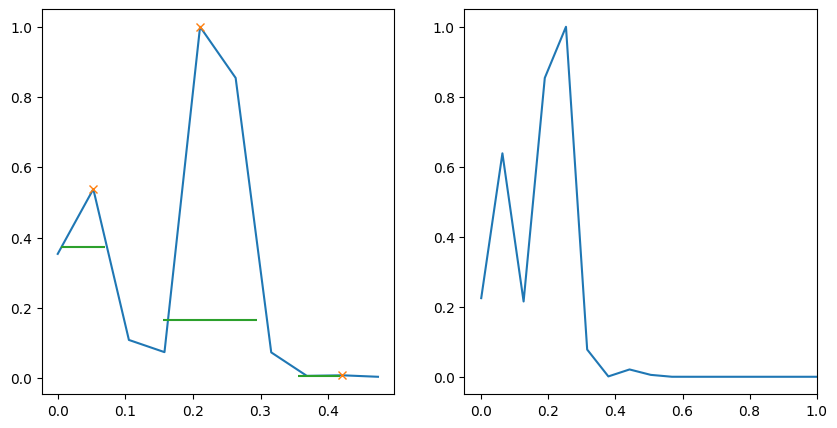

In [11]:
## Let's plot spectral dencity of the initial sifnal

# here fs is sampling frequency
fxx_sm, Pxx_den_sm = welch(np.real(sig_sm), fs = N/sig_len, nperseg=250)
fxx, Pxx_den = welch(np.real(sig), fs=1, nperseg = sig_len)

den_peaks, _ = find_peaks(Pxx_den)
den_width = signal.peak_widths(Pxx_den, den_peaks, rel_height=0.9)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(fxx, Pxx_den/np.max(Pxx_den))
ax[0].plot(fxx[den_peaks], Pxx_den[den_peaks]/np.max(Pxx_den),'x')
ax[0].hlines(den_width[1]/np.max(Pxx_den), den_width[2]*0.5/len(fxx),den_width[3]*0.5/len(fxx), color="C2")
ax[1].plot(fxx_sm, Pxx_den_sm/np.max(Pxx_den_sm))
ax[1].set_xlim(-0.05, 1)

print(den_width[1:])

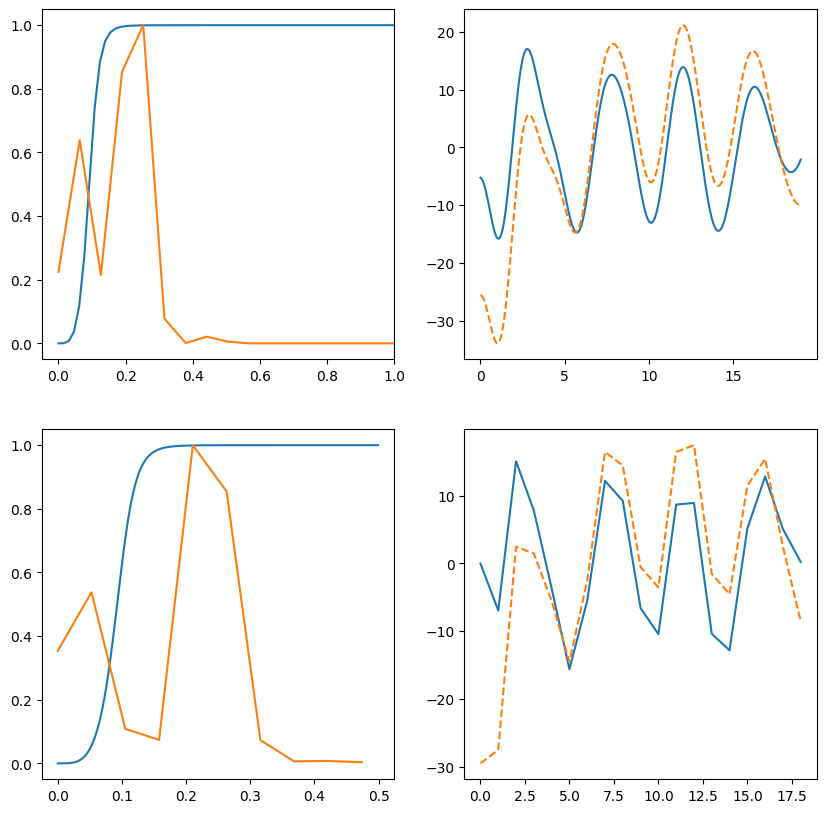

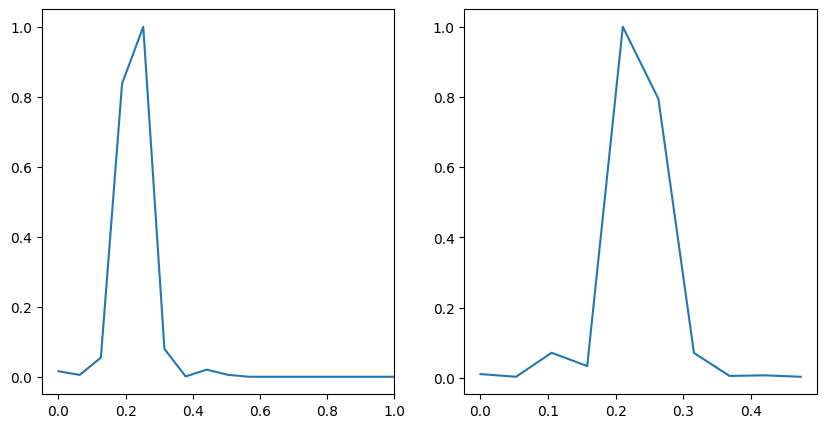

In [12]:
# test my_butter_high on original_signal and smoothed signal

b_s, a_s = sigan.my_butter_high(fq0 = 1/sig_len,fs=0.5*N/sig_len, nl = 1)
w_s, h_s = freqz(b_s, a_s, fs = 2*np.pi*N/sig_len)
sig_sm_flt_h = signal.filtfilt(b_s, a_s, y)

b, a = sigan.my_butter_high(fq0 = 1/sig_len,fs=0.5, nl = 1)
w, h = freqz(b, a)
sig_flt_h = signal.filtfilt(b, a, sig)

fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(w_s/2/np.pi, np.abs(h_s), fxx_sm, Pxx_den_sm/np.max(Pxx_den_sm))
ax[0,0].set_xlim(-0.05,1)
ax[0,1].plot(sig_sm_x, sig_sm_flt_h)
ax[0,1].plot(sig_sm_x, np.real(y), '--')

ax[1,0].plot(w/2/np.pi, np.abs(h), fxx, Pxx_den/np.max(Pxx_den))
ax[1,1].plot(sig_x, sig_flt_h)
ax[1,1].plot(sig_x, np.real(sig), '--')

fig, ax = plt.subplots(1,2, figsize=(10,5))
# here fs is sampling frequency
fxx_sm_flt, Pxx_den_sm_flt = welch(np.real(sig_sm_flt_h), fs = N/sig_len, nperseg=250)
fxx_flt, Pxx_den_flt = welch(np.real(sig_flt_h), fs=1, nperseg = sig_len)
ax[0].plot(fxx_sm_flt, np.real(Pxx_den_sm_flt/np.max(Pxx_den_sm_flt)))
ax[0].set_xlim(-0.05,1)
ax[1].plot(fxx_flt, np.real(Pxx_den_flt/np.max(Pxx_den_flt)))

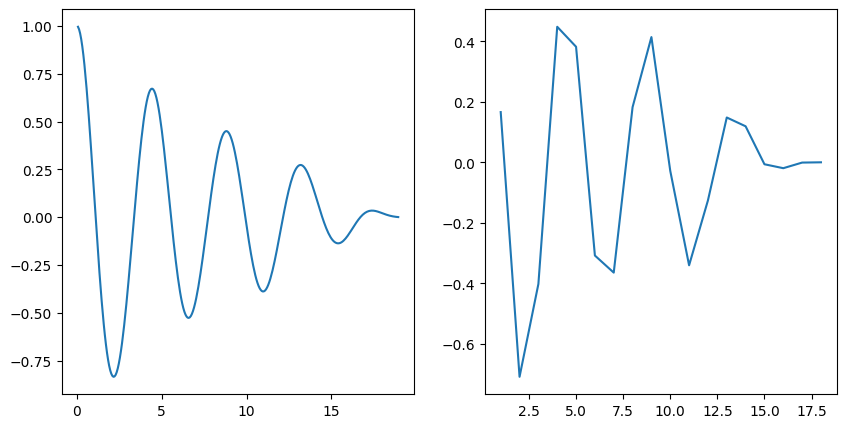

In [29]:
dt = sig_len/N

def auto_corr(signal, sig_point_num, dt):
    # signal - signal to find autocorrelation of
    # sig_point_num - number of data points in signal
    
    sig_cor = correlate(signal, signal, mode = 'full')
    sig_cor_lag = correlation_lags(sig_point_num, sig_point_num,  mode = 'full')*dt

    return sig_cor_lag[sig_point_num:], sig_cor[sig_point_num:]/np.max(sig_cor)
    
sig_sm_cor_lag, sig_sm_cor = auto_corr(sig_sm_flt_h, N, dt)
sig_cor_lag, sig_cor = auto_corr(sig_flt_h, sig_len, 1)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(sig_sm_cor_lag, sig_sm_cor)
ax[1].plot(sig_cor_lag, sig_cor)

num_of_peaks: 8
mean_period: 4.360952380952382
mean_freq: 0.22930770910679182


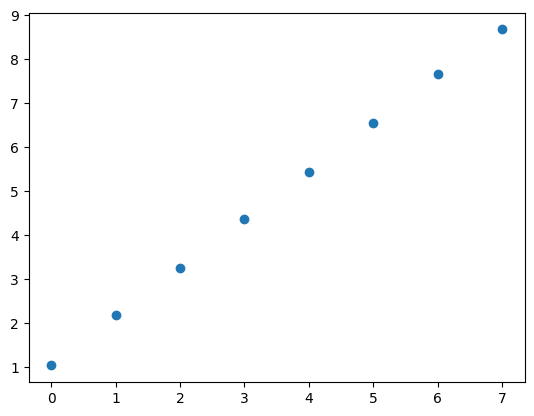

In [30]:
from scipy.signal import argrelextrema
peaks_max = argrelextrema(sig_sm_cor, np.greater)
peaks_min = argrelextrema(sig_sm_cor, np.less)

peaks = np.concatenate((peaks_max[0], peaks_min[0]))
peaks.sort()
peak_count = len(peaks)
peak_num = list(range(len(peaks)))

plt.plot(peak_num, 0.5*peaks*dt, 'o')

mean_period = 2*np.mean(np.diff(peaks))*dt
print('num_of_peaks: '+str(peak_count))
print('mean_period: '+str(mean_period))
print('mean_freq: ' + str(1/mean_period))

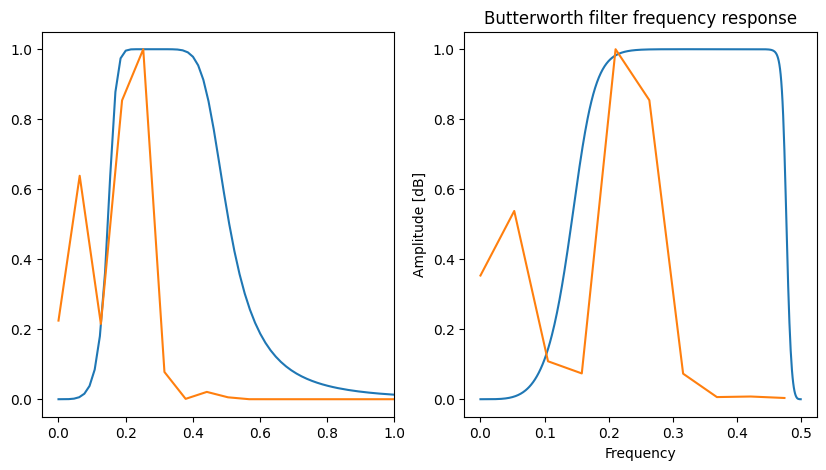

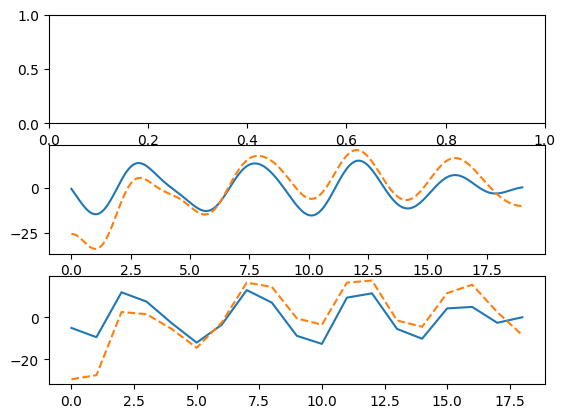

In [26]:
# test my_butter on smoothed and original signal 
peak_count=3

b_s, a_s = sigan.my_butter(fq0=1/sig_len, fs=N/sig_len, peak_count=peak_count)# for smoothed signal     
w, h = freqz(b_s, a_s, fs=2*np.pi*N/sig_len)
#fxx, Pxx_den = welch(np.real(sig_sm), nperseg=150)

fig, ax = plt.subplots(1,2, figsize=(10,5))

plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency')
plt.ylabel('Amplitude [dB]')

ax[0].plot(w/2/np.pi, np.abs(h), fxx_sm, Pxx_den_sm/np.max(Pxx_den_sm))
ax[0].set_xlim(-0.05,1)

sig_sm_flt = signal.filtfilt(b_s, a_s, sig_sm)

b, a = sigan.my_butter(fq0=1/sig_len, fs=1,  peak_count=peak_count) # for original signal (Niquist frequency is different)
w, h = freqz(b, a)
#fxx, Pxx_den = welch(np.real(sig), nperseg=sig_len)

ax[1].plot(w/2/np.pi, np.abs(h), fxx, Pxx_den/np.max(Pxx_den))

sig_flt = signal.filtfilt(b, a, sig, padlen=0)

fig, ax = plt.subplots(3,1)
#ax[0].plot(f_new[0:N//2], np.abs(fft(sig_sm_flt)[0:N//2]))
#ax[0].set_xlim(-0.05,1)
ax[1].plot(sig_sm_x, sig_sm_flt)
ax[1].plot(sig_sm_x, np.real(sig_sm), '--')
ax[2].plot(sig_x, sig_flt)
ax[2].plot(sig_x, np.real(sig), '--')

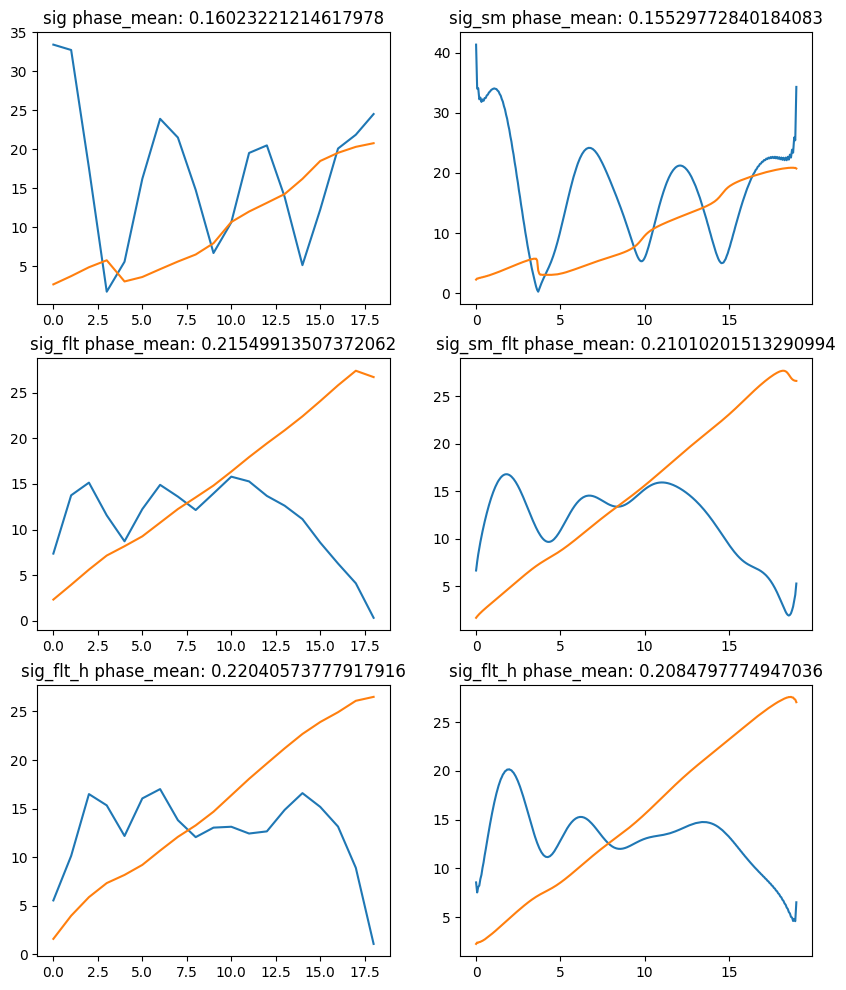

In [25]:
# Analizing instant phase and amplitude envelope 
# by restoring analitical signal with Hilberl transform

sig_list = [sig, sig_sm, sig_flt, sig_sm_flt, sig_flt_h, sig_sm_flt_h]
sig_x_list = [sig_x, sig_sm_x, sig_x, sig_sm_x, sig_x, sig_sm_x]

amp_env = []
instant_phase = []

for y in sig_list:
    anal_y = hilbert(np.real(y))
    amp_env.append(np.abs(anal_y))
    instant_phase.append(np.unwrap(np.angle(anal_y)))


fig, ax = plt.subplots(3,2, figsize=(10,12))

ax[0,0].plot(sig_x_list[0], amp_env[0])
ax[0,0].plot(sig_x_list[0], instant_phase[0])
ax[0,0].set_title('sig phase_mean: '+ str(sigan.phase_vel(instant_phase[0], 1)))

ax[0,1].plot(sig_x_list[1], amp_env[1])
ax[0,1].plot(sig_x_list[1], instant_phase[1])
ax[0,1].set_title('sig_sm phase_mean: '+ str(sigan.phase_vel(instant_phase[1], sig_len/N)))

ax[1,0].plot(sig_x_list[2], amp_env[2])
ax[1,0].plot(sig_x_list[2], instant_phase[2])
ax[1,0].set_title('sig_flt phase_mean: '+ str(sigan.phase_vel(instant_phase[2], 1)))

ax[1,1].plot(sig_x_list[3], amp_env[3])
ax[1,1].plot(sig_x_list[3], instant_phase[3])
ax[1,1].set_title('sig_sm_flt phase_mean: '+ str(sigan.phase_vel(instant_phase[3], sig_len/N)))

ax[2,0].plot(sig_x_list[4], amp_env[4])
ax[2,0].plot(sig_x_list[4], instant_phase[4])
ax[2,0].set_title('sig_flt_h phase_mean: '+ str(sigan.phase_vel(instant_phase[4], 1)))

ax[2,1].plot(sig_x_list[5], amp_env[5])
ax[2,1].plot(sig_x_list[5], instant_phase[5])
ax[2,1].set_title('sig_flt_h phase_mean: '+ str(sigan.phase_vel(instant_phase[5], sig_len/N)))

plt.show()

#print('phase_mean: '+ str(np.mean(np.diff(instant_phase))))